## Course 1 Getting Started with TensorFlow 2

--- 

#### 1.4.1 Saving and loading model weights

In [20]:
# Example for loading the weights of the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential([
    Dense(64, activation = 'sigmoid', input_shape = (10,)),
    Dense(1)
])

model.save_weights('my_model')

In [21]:
model.load_weights('my_model')

- Load and Inspect of CIFAR-10 dataset

In [22]:
import tensorflow as tf

In [23]:
# Import the CIFAR-10 dataset and rescale the pixel values

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
y_train = y_train / 255.0

# Use smaller subset -- speeds things up
x_test = x_test[:32000]
y_test = y_test[:32000]

In [24]:
len(x_train)

50000

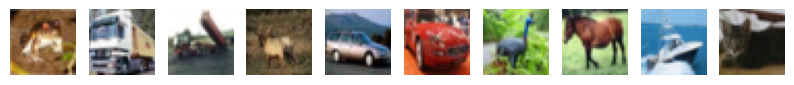

In [25]:
# Plot the first 10 CIFAR-10 images

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize = (10,1))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[i])

- Introduce two useful functions

In [26]:
# Introduce function to test model accuracy

def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x = x_test, y = y_test, verbose = 0)
    print(f'accuracy: {test_acc :0.3f}')

In [27]:
# Introduce function that creates a new instance of a simple CNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

def get_new_model ():
    model = Sequential([
        Conv2D(filters = 16, input_shape = (32,32,3), kernel_size = (3,3), activation = 'relu', name = 'conv_1'),
        Conv2D(filters = 8, kernel_size = (3,3), activation = 'relu', name = 'conv_2'),
        MaxPooling2D(pool_size = (4,4), name = 'pool_1'),
        Flatten(name = 'flatten'),
        Dense(32, activation = 'relu', name = 'dense_1'),
        Dense(10, activation = 'sigmoid', name = 'dense_2')
    ])
    model.compile(
        optimizer = 'adam',
        loss ='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

- Create simple convolutional neural network classifier

In [28]:
# Create an instance of the model and show model summary

model = get_new_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 conv_2 (Conv2D)             (None, 28, 28, 8)         1160      
                                                                 
 pool_1 (MaxPooling2D)       (None, 7, 7, 8)           0         
                                                                 
 flatten (Flatten)           (None, 392)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                12576     
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 14514 (56.70 KB)
Trainable params: 14514

In [29]:
# Test accuracy of the untrained model, around 10% (random)

get_test_accuracy(model, x_test, y_test)

accuracy: 0.107


- Train model with checkpoints

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [31]:
# Create Tensorflow checkpoint object

checkpoint_path = 'model_checkpoints/checkpoint'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             frequency = 'epoch',
                             save_weights_only=True,
                             verbose = 1)

In [32]:
# Fit model, with simple checkpoint which saves (and overwrites) model weights every epoch
model.fit(x_train, y_train, epochs = 3, callbacks = [checkpoint])

Epoch 1/3
1563/1563 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 0.0998
Epoch 1: saving model to model_checkpoints\checkpoint
1563/1563 [==============================] - 20s 13ms/step - loss: 0.0133 - accuracy: 0.0998
Epoch 2/3
1560/1563 [============================>.] - ETA: 0s - loss: 6.5456e-07 - accuracy: 0.1001
Epoch 2: saving model to model_checkpoints\checkpoint
1563/1563 [==============================] - 20s 13ms/step - loss: 7.9685e-07 - accuracy: 0.1000
Epoch 3/3
1560/1563 [============================>.] - ETA: 0s - loss: 1.6741e-07 - accuracy: 0.1000
Epoch 3: saving model to model_checkpoints\checkpoint
1563/1563 [==============================] - 20s 13ms/step - loss: 1.6715e-07 - accuracy: 0.1000


In [33]:
# Evaluate the performance of the trained model

get_test_accuracy(model, x_test, y_test)

accuracy: 0.100


- Create new model, load weights

In [34]:
model = get_new_model()
get_test_accuracy(model, x_test, y_test)

accuracy: 0.101


In [35]:
model.load_weights(checkpoint_path)
get_test_accuracy(model, x_test, y_test)

accuracy: 0.100


#### 1.4.2 Explanation of saved files

```
-rw-r--r--  1 aph416  staff    87B  2 Nov 17:04 checkpoint
-rw-r--r--  1 aph416  staff   2.0K  2 Nov 17:04 checkpoint.index
-rw-r--r--  1 aph416  staff   174K  2 Nov 17:04 checkpoint.data-00000-of-00001
```

`checkpoint` 
This file is by far the smallest, at only 87 bytes. It's actually so small that we can just look at it directly. It's a human readable file with the following text:
```
model_checkpoint_path: "checkpoint"
all_model_checkpoint_paths: "checkpoint"
```
This is metadata that indicates where the actual model data is stored.

`checkpoint.index`
This file tells TensorFlow which weights are stored where. When running models on distributed systems, there may be different *shards*, meaning the full model may have to be recomposed from multiple sources. In the last notebook, you created a single model on a single machine, so there is only one *shard* and all weights are stored in the same place.

`checkpoint.data-00000-of-00001`
This file contains the actual weights from the model. It is by far the largest of the 3 files. Recall that the model you trained had around 14000 parameters, meaning this file is roughly 12 bytes per saved weight.

#### 1.4.3 Model Saving Criteria

In [36]:
'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential([
    Dense(16, activation = 'relu'),
    Dropout(0,3),
    Dense(3, activation = 'softmax')
])

model.compile(
    optimizer='rmsprop',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc','mae']
)

checkpoint = ModelCheckpoint('training_run_1/my_model', save_weights_only=True, save_freq = epochs, save_best_only = True, monitor = 'val_loss)

model.fit(X_train, y_train, validation_data=(X_val, Y_val), epochs = 10, batch_size=10, callbacks=[checkpoint])
'''

"\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense, Dropout\nfrom tensorflow.keras.callbacks import ModelCheckpoint\n\nmodel = Sequential([\n    Dense(16, activation = 'relu'),\n    Dropout(0,3),\n    Dense(3, activation = 'softmax')\n])\n\nmodel.compile(\n    optimizer='rmsprop',\n    loss = 'sparse_categorical_crossentropy',\n    metrics = ['acc','mae']\n)\n\ncheckpoint = ModelCheckpoint('training_run_1/my_model', save_weights_only=True, save_freq = epochs, save_best_only = True, monitor = 'val_loss)\n\nmodel.fit(X_train, y_train, validation_data=(X_val, Y_val), epochs = 10, batch_size=10, callbacks=[checkpoint])\n"

- Preparation process with previous codes

In [70]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:1000]
y_test = y_test[:1000]

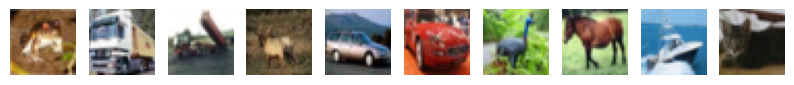

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize = (10,1))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[i])

In [71]:
def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f'accuracy : {test_acc : 0.3f}')

In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D

def get_new_model():
    model = Sequential([
        Conv2D(filters = 16, input_shape = (32,32,3), kernel_size = (3,3), activation = 'relu', name = 'Conv_1'),
        Conv2D(filters = 8, kernel_size = (3,3), activation = 'relu', name = 'Conv_2'),
        MaxPooling2D(pool_size=(4,4), name = 'pool_1'),
        Flatten(name = 'Flatten'),
        Dense(32, activation='relu', name = 'Dense_1'),
        Dense(10, activation = 'softmax', name = 'Dense_2')
    ])
    model.compile(
        optimizer = 'adam',
        loss = 'sparse_categorical_crossentropy',
        metrics = ['acc']
    )
    return model

In [42]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [43]:
# Create Tensorflow checkpoint object with epoch and batch details

checkpoint_5000_path = \
    'model_checkpoints_5000/checkpoint_{epoch:02d}_{bathc:04d}'
checkpoint_5000 = ModelCheckpoint(
    filepath = checkpoint_5000_path,
    save_weights_only=True,
    save_freq = 5000,
    verbose = 1
)

In [44]:
# Create and fit model with checkpoint

model = get_new_model()
model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test), batch_size=10, callbacks = [checkpoint_5000])

Epoch 1/3
1000/1000 [==============================] - 10s 9ms/step - loss: 1.8805 - acc: 0.3098 - val_loss: 1.6493 - val_acc: 0.4200
Epoch 2/3
1000/1000 [==============================] - 9s 9ms/step - loss: 1.5116 - acc: 0.4523 - val_loss: 1.4361 - val_acc: 0.5060
Epoch 3/3
1000/1000 [==============================] - 8s 8ms/step - loss: 1.3742 - acc: 0.5102 - val_loss: 1.3936 - val_acc: 0.4950


In [46]:
! ls -lh model_checkpoint_5000

SyntaxError: invalid syntax (2066128273.py, line 1)

In [47]:
import sys
!{sys.executable} ls -lh model_checkpoint_5000

'c:\Users\bokeu\Documents\Coursera\TensorFlow'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


- Work with model saving criteria

In [48]:
# Use tiny trianing and test set -- will overfit!
x_train = x_train[:100]
y_train = y_train[:100]
x_test = x_test[:100]
y_test = y_test[:100]

In [58]:
# create a new instance of untrained model
model = get_new_model()

In [59]:
# Create tensorflow checkpoint object which monitors the validation accuracy
checkpoint_best_path = 'model_checkpoints_best/checkpont'
checkpoint_best = ModelCheckpoint(
    filepath = checkpoint_best_path,
    save_weights_only=True,
    verbose=1,
    save_freq = 'epoch',
    monitor = 'val_acc',
    save_best_only = True
)

In [60]:
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=10, callbacks=[checkpoint_best], verbose = 0)


Epoch 1: val_acc improved from -inf to 0.05000, saving model to model_checkpoints_best\checkpont

Epoch 2: val_acc improved from 0.05000 to 0.07000, saving model to model_checkpoints_best\checkpont

Epoch 3: val_acc did not improve from 0.07000

Epoch 4: val_acc improved from 0.07000 to 0.08000, saving model to model_checkpoints_best\checkpont

Epoch 5: val_acc did not improve from 0.08000

Epoch 6: val_acc improved from 0.08000 to 0.11000, saving model to model_checkpoints_best\checkpont

Epoch 7: val_acc did not improve from 0.11000

Epoch 8: val_acc improved from 0.11000 to 0.12000, saving model to model_checkpoints_best\checkpont

Epoch 9: val_acc improved from 0.12000 to 0.14000, saving model to model_checkpoints_best\checkpont

Epoch 10: val_acc did not improve from 0.14000

Epoch 11: val_acc improved from 0.14000 to 0.16000, saving model to model_checkpoints_best\checkpont

Epoch 12: val_acc improved from 0.16000 to 0.17000, saving model to model_checkpoints_best\checkpont

Epo

<Axes: >

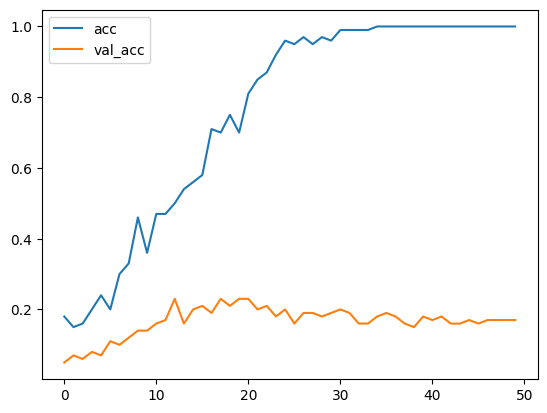

In [63]:
import pandas as pd

df = pd.DataFrame(history.history)
df.plot(y=['acc', 'val_acc'])

In [66]:
new_model = get_new_model()
new_model.load_weights(checkpoint_best_path)
get_test_accuracy(new_model, x_test, y_test)

accuracy :  0.230


#### 1.4.4 Saving the Entire Model

- Create checkpoint that saves whole model, not just weights

In [74]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [75]:
# Create Tensroflow checkpoint object

checkpoint_path = 'model_checkpoints'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only = False,
                             frequency = 'epoch',
                             verbose = 1)

In [76]:
# Create and fit model with checkpoint

model = get_new_model()
model.fit(x_train, y_train, epochs = 3, callbacks = [checkpoint])

Epoch 1/3
311/313 [============================>.] - ETA: 0s - loss: 1.9486 - acc: 0.2925
Epoch 1: saving model to model_checkpoints


INFO:tensorflow:Assets written to: model_checkpoints\assets


INFO:tensorflow:Assets written to: model_checkpoints\assets


313/313 [==============================] - 6s 16ms/step - loss: 1.9462 - acc: 0.2927
Epoch 2/3
310/313 [============================>.] - ETA: 0s - loss: 1.5866 - acc: 0.4236
Epoch 2: saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints\assets


INFO:tensorflow:Assets written to: model_checkpoints\assets


313/313 [==============================] - 5s 15ms/step - loss: 1.5866 - acc: 0.4238
Epoch 3/3
312/313 [============================>.] - ETA: 0s - loss: 1.4657 - acc: 0.4731
Epoch 3: saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints\assets


INFO:tensorflow:Assets written to: model_checkpoints\assets


313/313 [==============================] - 5s 16ms/step - loss: 1.4654 - acc: 0.4733


- Inspect what the checkpoint has created

In [77]:
# Have a look at what the checkpoint creates

In [78]:
# Enter variables directory

In [79]:
get_test_accuracy(model, x_test, y_test)

accuracy :  0.488


In [80]:
from tensorflow.keras.models import load_model

In [81]:
model = load_model(checkpoint_path)
get_test_accuracy(model, x_test, y_test)

accuracy :  0.488


- Use the h.5 format to save model

In [83]:
model.save('my_model.h5')

c:\Users\bokeu\Documents\Coursera\TensorFlow 2 with Python\TF2env\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 1.4.5 Saving model architecture only

In [86]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import json
import numpy as np

- Accessing a model's configuration

In [88]:
# Build the model

model = Sequential([
    Dense(32, input_shape = (32,32,3), activation = 'relu', name = 'Dense_1'),
    Dense(10, activation = 'softmax', name = 'Dense_2')
])

In [89]:
# Get the model config

config_dict = model.get_config()
print(config_dict)

{'name': 'sequential_14', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 32, 32, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'Dense_1_input'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'Dense_1', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 32, 32, 3), 'units': 32, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 32, 32, 3)}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': '

- Creating a new model from the config

In [90]:
# Create a model from the config dictionary

model_same_config = tf.keras.Sequential.from_config(config_dict)

In [91]:
# Check the new model is the same architecture

print('Same config',
      model.get_config() == model_same_config.get_config())
print('Same value for first weight matrix',
      np.allclose(model.weights[0].numpy(), model_same_config.weights[0].numpy()))

Same config True
Same value for first weight matrix False


- Other file formats: JSON and YAML

In [92]:
# Convert the model to JSON

json_string = model.to_json()
print(json_string)

{"class_name": "Sequential", "config": {"name": "sequential_14", "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 32, 32, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "Dense_1_input"}, "registered_name": null}, {"module": "keras.layers", "class_name": "Dense", "config": {"name": "Dense_1", "trainable": true, "dtype": "float32", "batch_input_shape": [null, 32, 32, 3], "units": 32, "activation": "relu", "use_bias": true, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "class_name": "Zeros", "config": {}, "registered_name": null}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "registered_name": null, "build_config": {"input_shape": [null, 32, 32, 3]}}, {"module": "keras.layers", "cla

In [ ]:
# Write out Json Config file

with open('config_json', 'w') as f:
    json.dump(json_string, f)
del json_string

In [ ]:
# Read in Json config file again

with open('config.json', 'r') as f:
    json_string = json.load(f)

In [ ]:
# Reinitialize the model

model_same_config = tf.keras.models.model_from_json(json_string)

In [ ]:
# Check the new model is the same architecture, but different weights

print('Same config',
      model.get_config() == model_same_config.get_config())
print('Same value for first weight matirx',
      np.allclose(model.weights[0].numpy(), model_same_config.weights[0].numpy()))

#### 1.4.6 Loading pre=trained Keras models

--> Refer to the Tensorlfow model part

In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

model = ResNet50(weights = 'imagenet', include_top = False, ) # ~/.keras/models

img_input = image.load_img('my_picture.jpg', target_size = (224,224))
img_input = image.img_to_array(img_input)
img_input = preproccess_input(img_input[np.newaxis, ...])

- Import and build Keras ResNet50 model

In [7]:
from tensorflow.keras.models import load_model

In [20]:
# Build Keras ResNet50 model
model = load_model('Keras_Resnet50.h5')
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

- Import and preprocess 3 sample images

In [22]:
# Import 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img('data/lemon.jpg', target_size = (224,224))
viaduct_img = load_img('data/viaduct.jpg', target_size = (224,224))
water_tower_img = load_img('data/water_tower.jpg', target_size = (224,224))

- Use ResNet50 model to classify images

In [26]:
# Useful Function : presents top 5 predictions and probabilities

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...]
    x = preprocess_input(x)
    preds = decode_predictions(model.predict(x), top = 5)
    top_preds = pd.DataFrame(columns = ['prediction', 'probability'],
                             index = np.arange(5)+1)
    for i in range(5):
        top_preds.loc[i+1, 'prediction'] = preds[0][i][1]
        top_preds.loc[i+1, 'probability'] = preds[0][i][2]
    return top_preds

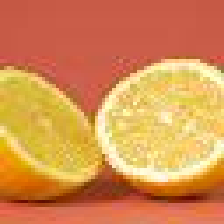

In [27]:
lemon_img

In [28]:
# Display Top 5 predictions
get_top_5_predictions(lemon_img)

35363/35363 [==============================] - 0s 1us/step


,prediction,probability
1,consomme,0.237066
2,eggnog,0.226408
3,lemon,0.199255
4,face_powder,0.030634
5,ladle,0.030447


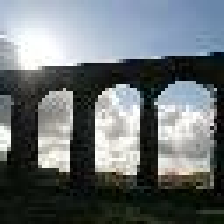

In [29]:
viaduct_img

In [30]:
get_top_5_predictions(viaduct_img)

1/1 [==============================] - 0s 90ms/step


,prediction,probability
1,vault,0.433362
2,viaduct,0.11364
3,prison,0.107957
4,window_screen,0.067979
5,megalith,0.016871


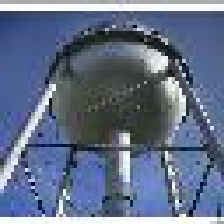

In [31]:
water_tower_img

In [32]:
get_top_5_predictions(water_tower_img)

1/1 [==============================] - 0s 102ms/step


,prediction,probability
1,solar_dish,0.483133
2,ladle,0.165878
3,planetarium,0.101512
4,strainer,0.052545
5,jigsaw_puzzle,0.023844


#### 1.4.7 Tensorflow Hub Modules

- Import and build Tensorflow Hub MobileNet v1 model

1. model_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
2. model = Sequential([hub.KerasLayer(module_url)])
3. model.build(input_shape = [None, 160, 160, 3])

In [40]:
import tensorflow_hub as hub
from tensorflow.keras.models import load_model, Sequential

In [43]:
# Build Google's Mobilenet v1 model
module = load_model('models/Tensorflow_MobileNet_v1')

model = Sequential(hub.KerasLayer(module))
model.build(input_shape=[None, 160, 160, 3])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_7 (KerasLayer)  (None, 1001)              1343049   
                                                                 
Total params: 1343049 (5.12 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1343049 (5.12 MB)
_________________________________________________________________


- Use Mobilenet model to classify images

In [44]:
# Import and preprocess 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img, img_to_array

lemon_img = load_img('data/lemon.jpg', target_size=(160,160))
viaduct_img = load_img('data/viaduct.jpg', target_size=(160,160))
water_tower_img = load_img('data/water_tower.jpg', target_size=(160, 160))

In [45]:
# Read in categories text file

with open('data/imagenet_categories.txt') as txt_file:
    categories = txt_file.read().splitlines()

In [49]:
# Useful function : presents top 5 predictions

import numpy as np
import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...] /255.0
    preds = model.predict(x)
    top_preds = pd.DataFrame(columns = ['prediction'], index = np.arange(5)+1)
    sorted_index = np.argsort(-preds[0])
    for i in range(5):
        ith_pred = categories[sorted_index[i]]
        top_preds.loc[i+1, 'prediction'] = ith_pred

    return top_preds

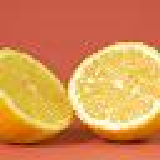

In [47]:
lemon_img

In [50]:
get_top_5_predictions(lemon_img)

1/1 [==============================] - 0s 51ms/step


,prediction
1,shower cap
2,tray
3,Petri dish
4,candle
5,brassiere


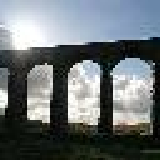

In [51]:
viaduct_img

In [52]:
get_top_5_predictions(viaduct_img)

1/1 [==============================] - 0s 29ms/step


,prediction
1,viaduct
2,dam
3,pier
4,monastery
5,prison


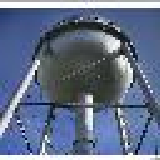

In [53]:
water_tower_img

In [54]:
get_top_5_predictions(water_tower_img)

1/1 [==============================] - 0s 26ms/step


,prediction
1,solar dish
2,water tower
3,jigsaw puzzle
4,castle
5,aircraft carrier
